In [1]:
from utils import config_utils, utils, synthetic_dataset, GAE_trainer, analyze_utils, GAES_trainer, AAE_trainer
from models import GAE
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import manifold 
import torch
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc

Starting generate synthetic data
Finish generating synthetic data
Starting split synthetic data
Normal major nc:90458, c:4080
Normal minor nc:90817, c:165719
Abnormal major nc:3040, c:3146
Abnormal minor nc:2966, c:5466
Initial GAE


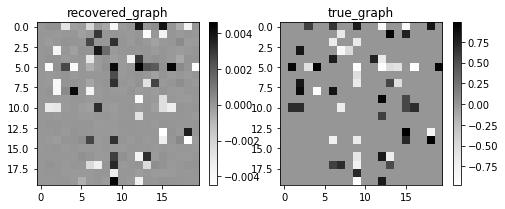

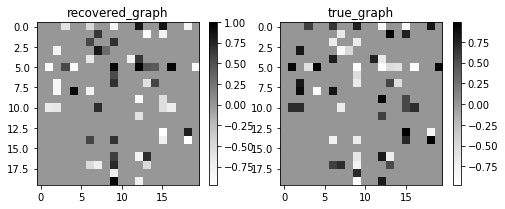

Start training GAES
Initial loss: 8.18936824798584
Final loss: 0.8369194269180298


In [2]:
parser = config_utils.get_args()
args = parser.parse_args("")
options = vars(args)

# Reproducibility
utils.set_seed(options['seed'])

# Get dataset
print('Starting generate synthetic data')
dataset = synthetic_dataset.SyntheticDataset(options['n'] * 2500, options['d'], options['graph_type'], options['degree'], options['sem_type'],
                           options['noise_scale'], options['dataset_type'], options['x_dim'], options['alpha_cos'])
print('Finish generating synthetic data')
print('Starting split synthetic data')
df_train, df_eval, df_test, df_eval_set, df_train_cf, df_eval_cf, df_test_cf, df_eval_set_cf = utils.get_samples(dataset)
print('Initial GAE')
gae = GAE.GAE(len(df_train), options['d'], options['x_dim'], options['seed'], options['num_encoder_layers'],
                    options['num_decoder_layers'],
                    options['hidden_size'], options['latent_dim'], options['l1_graph_penalty'], options['learning_rate'], options['device'])

gae_trainer = GAE_trainer.GAETrainner(options['init_rho'], options['rho_thres'], options['h_thres'], options['rho_multiply'],
                          options['init_iter'], options['learning_rate'], options['h_tol'],
                          options['early_stopping'], options['early_stopping_thres'])
W_est = gae_trainer.train(gae, df_train.iloc[:, :-3].values.reshape(-1, options['d'], 1), dataset.W,
                          options['graph_thres'],
                          options['max_iter'], options['iter_step'])
W_est[:, 0] = 0.0

# Plot raw recovered graph
analyze_utils.plot_recovered_graph(W_est, dataset.W,
                     save_name='output/raw_recovered_graph.png')

W_est_old = W_est.copy()
W_est = W_est / np.max(np.abs(W_est))  # Normalize
W_est[np.abs(W_est) < options['graph_thres']] = 0  # Thresholding

analyze_utils.plot_recovered_graph(W_est, dataset.W,
                     save_name='output/thresholded_recovered_graph.png')
results_thresholded = analyze_utils.count_accuracy(dataset.W, W_est)

print('Start training GAES')
gaes = GAES_trainer.GAESTrainner(gae.net.encoder, df_train.iloc[:, :-3].values.reshape(-1, options['d'], options['x_dim']), W_est_old,
                    max_epoch=200, n=len(df_train), d=options['d'], device=options['device'])
gaes.train()

In [3]:
X_do = gaes.net.get_result(torch.Tensor(df_train.iloc[:, :-3].values.astype(np.float32).reshape(-1, 20, 1)).to(options['device']),
                               do=1).detach().cpu().numpy().reshape(-1, 20)[:, 1:]
X = df_train.iloc[:, 1:-3].values.astype(np.float32)
X_cf = df_train_cf.iloc[:, 1:-3].values.astype(np.float32)

In [4]:
utils.set_seed(options['seed'])
idx = np.random.choice(len(X), 500)
X_orgs = X[idx]
X_dos = X_do[idx]
X_cfs = X_cf[idx]

In [5]:
seed = 0

In [6]:
utils.set_seed(options['seed'])
# seed += 1
# tsne = manifold.TSNE(n_components=2, init='random', perplexity=150, random_state=80, n_iter=5000, n_iter_without_progress = 400, learning_rate=1020)
# tsne = manifold.TSNE(n_components=2, init='random', random_state=1, n_iter_without_progress = 1000, learning_rate=1000, perplexity=150, n_iter=10000)
tsne = manifold.TSNE(n_components=2, init='random', random_state=1, n_iter_without_progress = 200, learning_rate=1000, perplexity=100, n_iter=10000)
# tsne = manifold.MDS(n_components=2, random_state=0)
# tsne = manifold.Isomap(n_components=2)
# tsne = manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense', random_state=0)
# tsne = manifold.SpectralEmbedding(n_components=2, affinity='rbf')
# orgs = tsne.fit_transform(X_orgs)
dos = tsne.fit_transform(X_dos)
cfs = tsne.fit_transform(X_cfs)

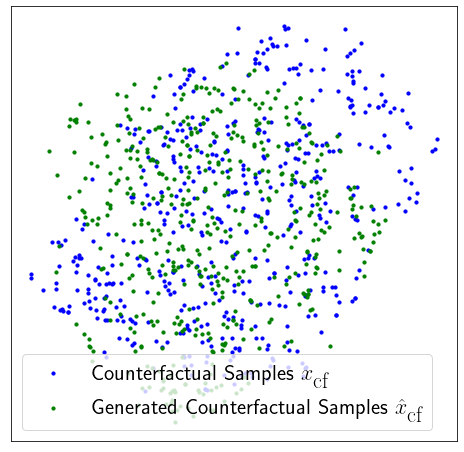

In [12]:
utils.set_seed(options['seed'])
matplotlib.rcParams['text.usetex'] = True
plt.figure(figsize=(8,8))
matplotlib.rcParams.update({'font.size': 22})
# plt.scatter(orgs[:,0],orgs[:,1], color = 'r', marker='o', s=10, alpha = 1.0,label = 'Observed Samples')
plt.scatter(cfs[:,0],cfs[:,1], color = 'b',marker='o', s=10, alpha = 1.0, label = r'Counterfactual Samples $x_{\textrm{cf}}$')
plt.scatter(dos[:,0],dos[:,1], color = 'g',marker='o', s=10, alpha = 1.0,label = r'Generated Counterfactual Samples $\hat{x}_\textrm{{cf}}$')

plt.legend(loc='best')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.show()
plt.savefig('tsne.jpg', dpi=300, bbox_inches='tight', pad_inches=0.01)